# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')


import tools as ds

In [2]:
crashes_initial = pd.read_csv('data/Crashes.csv')
parties = pd.read_csv('data/Parties.csv')

In [3]:
crashes_initial.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,7034739,2015,2015-08-22,3801,2015-02-26,1931,000985,RICHM,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.458750,37.779350
1,7035304,2014,2015-08-24,3801,2014-12-25,2245,A09861,INGLE,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.418788,37.710855
2,7202472,2016,2016-03-09,3801,2016-02-11,1100,1572,NaN,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.395850,37.781310
3,8042422,2016,2016-05-16,3801,2016-04-13,1050,001588,CENTR,3,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.399682,37.794241
4,8046723,2016,2016-05-18,3801,2016-04-16,1614,2472,MISIS,6,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.429839,37.761200


There are 80 columns describing a bike crash instance, with many containing code words that are interpreted here: https://tims.berkeley.edu/help/SWITRS.php#Codebook

In [4]:
crashes = ds.decode_switrs(crashes_initial, create_new_columns=True)

Created decoded column: WEATHER_1_DESC
Created decoded column: WEATHER_2_DESC
Created decoded column: COLLISION_SEVERITY_DESC
Created decoded column: TYPE_OF_COLLISION_DESC
Created decoded column: ROAD_SURFACE_DESC
Created decoded column: LIGHTING_DESC
Created decoded column: PRIMARY_COLL_FACTOR_DESC
Created decoded column: PCF_VIOL_CATEGORY_DESC
Created decoded column: DAY_OF_WEEK_DESC
Created decoded column: MVIW_DESC


In [5]:
crashes.isna().sum().sort_values(ascending = False).head(30)

CITY_DIVISION_LAPD      5094
TRUCK_ACCIDENT          5049
CALTRANS_DISTRICT       5039
RAMP_INTERSECTION       5039
ROUTE_SUFFIX            5038
POSTMILE                5038
POSTMILE_PREFIX         5038
CALTRANS_COUNTY         5038
LOCATION_TYPE           5036
SIDE_OF_HWY             5008
STATE_ROUTE             5005
MOTORCYCLE_ACCIDENT     5001
LATITUDE                4977
LONGITUDE               4977
PEDESTRIAN_ACCIDENT     4855
ALCOHOL_INVOLVED        4786
DIRECTION               3050
PCF_VIOL_SUBSECTION     2901
PCF_VIOLATION            596
REPORTING_DISTRICT       373
BEAT_NUMBER              347
CHP_VEHTYPE_AT_FAULT     262
TOW_AWAY                 155
POINT_Y                  121
POINT_X                  121
OFFICER_ID                 2
STATE_HWY_IND              1
WEATHER_1                  0
INTERSECTION               0
DISTANCE                   0
dtype: int64

None of the missing data is pertinent to our analysis, so we will not drop any records for missing this inofrmation.

In [6]:
crashes['COLLISION_DATE_CLEAN'] = pd.to_datetime(crashes['COLLISION_DATE'], format = 'mixed', errors = 'coerce')

# EDA - Trend Analysis 

### Covid 19

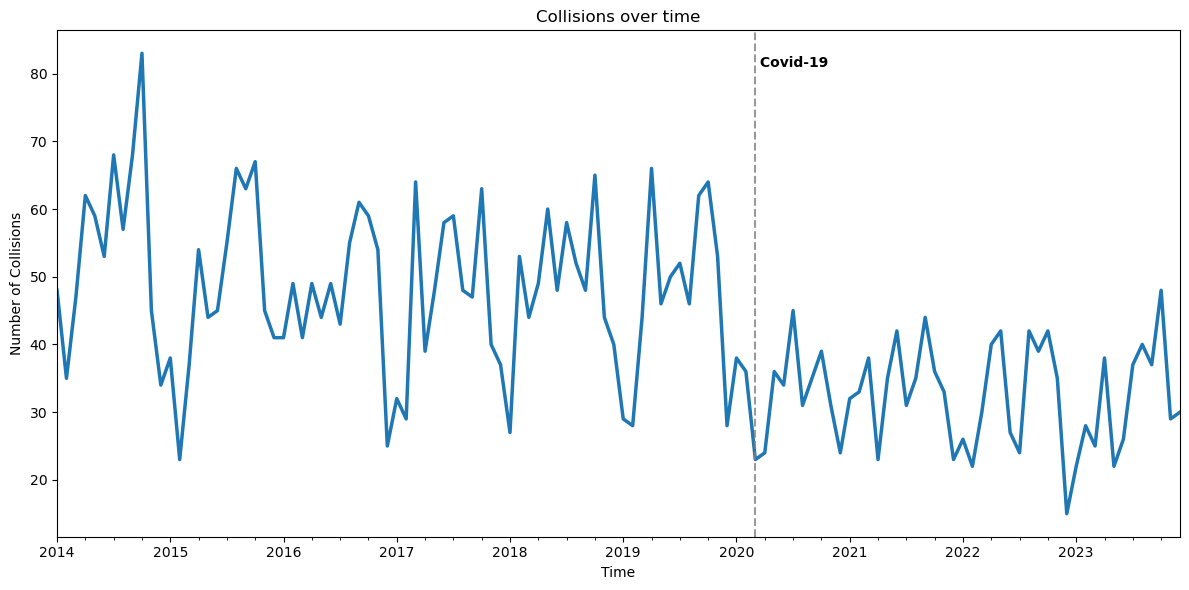

In [7]:
monthly_crashes = crashes.groupby(pd.Grouper(key = 'COLLISION_DATE_CLEAN', freq = 'ME')).size()
fig, ax = plt.subplots(figsize = (12,6))

monthly_crashes.plot(kind= 'line', ax = ax, linewidth = 2.5)


#covid line
ax.axvline(x=pd.Timestamp('2020-03-01'), color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
ax.text(x=pd.Timestamp('2020-03-01'), y=0.95, s=' Covid-19', color='black', transform=ax.get_xaxis_transform(),
         ha='left', va='top', fontweight='bold')


ax.set_title('Collisions over time')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Collisions')
plt.tight_layout()
plt.show()


We see that the number of crashes have not returned to Pre-covid numbers.

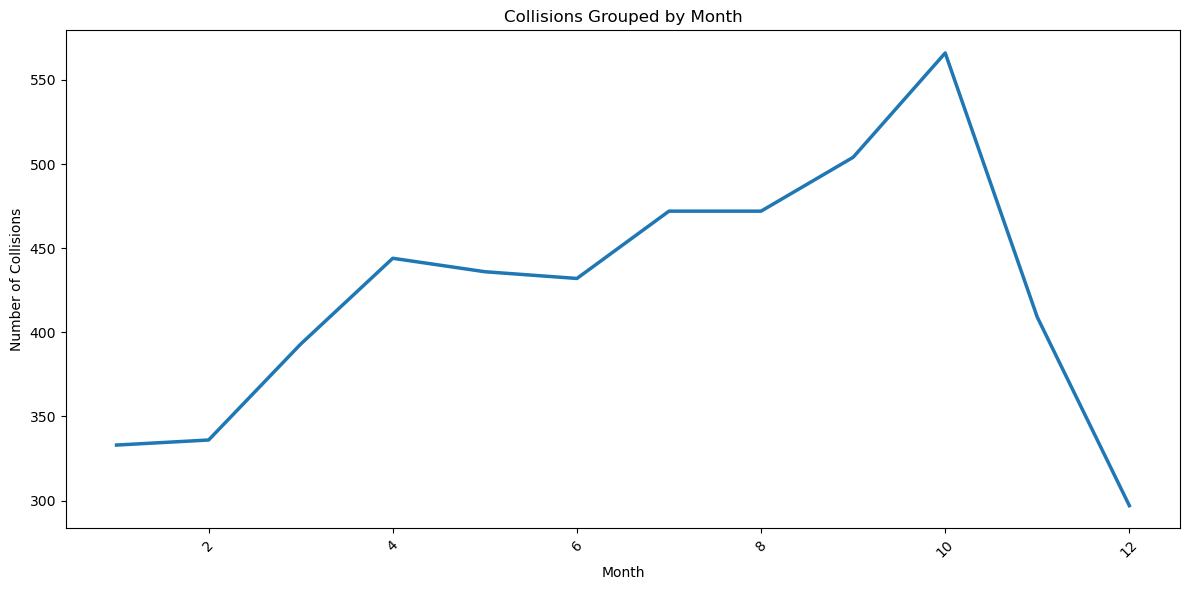

In [8]:

monthly_crashes = crashes.groupby(crashes['COLLISION_DATE_CLEAN'].dt.month).size()

fig, ax = plt.subplots(figsize = (12,6))

monthly_crashes.plot(kind= 'line', ax = ax, linewidth = 2.5)

ax.set_title('Collisions Grouped by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Collisions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Cumulatively, it seems that crashes peak around September/October, before falling sharply during winter periods

In [9]:
crashes['COLLISION_MONTH'] = crashes['COLLISION_DATE_CLEAN'].dt.month

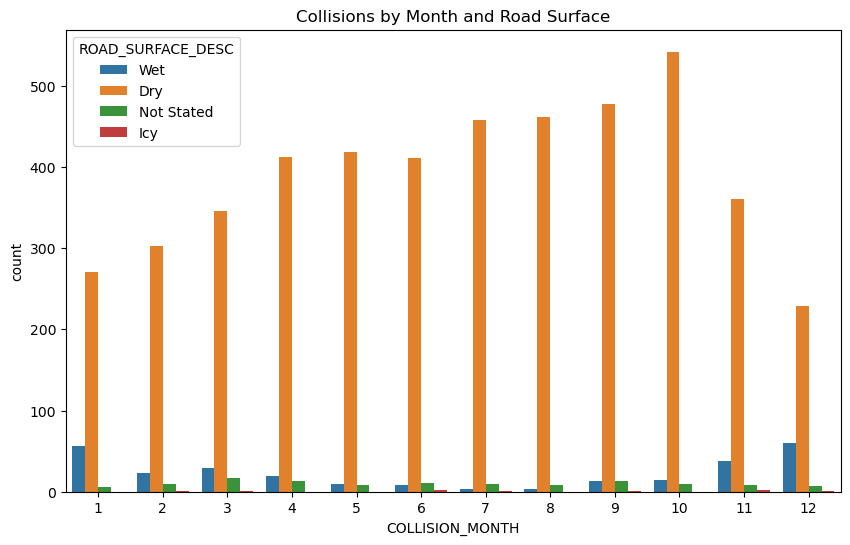

In [10]:
plt.figure(figsize=(10, 6))

sns.countplot(data=crashes, x='COLLISION_MONTH', hue='ROAD_SURFACE_DESC')
plt.title('Collisions by Month and Road Surface')
plt.show()

We thought maybe it was rainy season - guess not!

### Seasonal Variation

In [11]:
def get_season(date):
    month = date.month
    day = date.day
    if (month >= 3 and month <= 5):
        return 'Spring'
    elif (month >= 6 and month <= 8):
        return 'Summer'
    elif (month >= 9 and month <= 11):
        return 'Autumn'
    else:
        return 'Winter'

    
crashes['SEASON'] = crashes['COLLISION_DATE_CLEAN'].apply(get_season)

In [12]:
seasonly_crashes = crashes.groupby('SEASON').size()
seasonly_crashes

SEASON
Autumn    1479
Spring    1273
Summer    1376
Winter     966
dtype: int64

### Weekday vs Weekend

In [13]:
crashes.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,TYPE_OF_COLLISION_DESC,ROAD_SURFACE_DESC,LIGHTING_DESC,PRIMARY_COLL_FACTOR_DESC,PCF_VIOL_CATEGORY_DESC,DAY_OF_WEEK_DESC,MVIW_DESC,COLLISION_DATE_CLEAN,COLLISION_MONTH,SEASON
0,7034739,2015,2015-08-22,3801,2015-02-26,1931,000985,RICHM,4,5,...,Sideswipe,Dry,Dark - Street Lights,VC Section Violation,Improper Turning,Thursday,Right Turn,2015-02-26,2,Winter
1,7035304,2014,2015-08-24,3801,2014-12-25,2245,A09861,INGLE,4,5,...,Broadside,Dry,Dark - Street Lights,VC Section Violation,Unsafe Lane Change,Thursday,Right Turn,2014-12-25,12,Winter
2,7202472,2016,2016-03-09,3801,2016-02-11,1100,1572,NaN,4,5,...,Broadside,Dry,Daylight,VC Section Violation,Unsafe Lane Change,Thursday,Right Turn,2016-02-11,2,Winter
3,8042422,2016,2016-05-16,3801,2016-04-13,1050,001588,CENTR,3,5,...,Other,Dry,Daylight,VC Section Violation,Improper Passing,Wednesday,Right Turn,2016-04-13,4,Spring
4,8046723,2016,2016-05-18,3801,2016-04-16,1614,2472,MISIS,6,5,...,Sideswipe,Dry,Daylight,VC Section Violation,Other Hazardous Violation,Saturday,Right Turn,2016-04-16,4,Spring


# Fatal Crashes EDA

Total crashes: 5094
Fatal crashes: 23


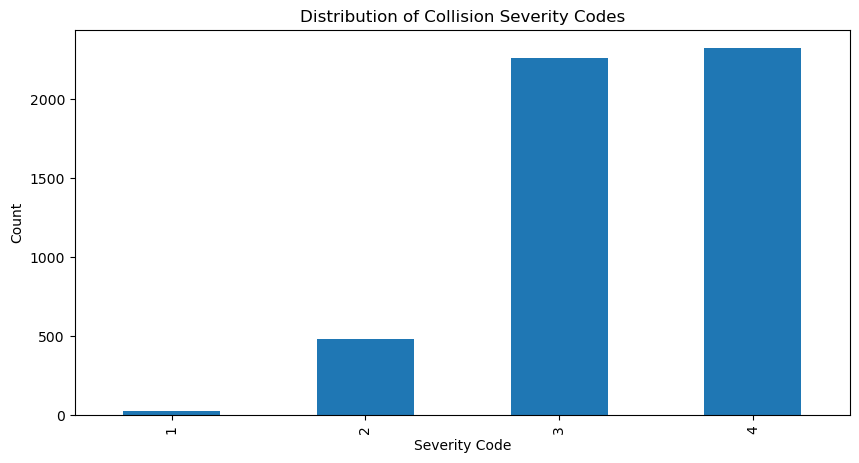

In [14]:
severity = crashes['COLLISION_SEVERITY'].dropna().astype(int)

# Fatal crashes: defined when NUMBER_KILLED > 0
fatal_crashes = crashes[crashes['NUMBER_KILLED'] > 0]

print("Total crashes:", len(crashes))
print("Fatal crashes:", len(fatal_crashes))

plt.figure(figsize=(10, 5))
severity.value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Collision Severity Codes")
plt.xlabel("Severity Code")
plt.ylabel("Count")
plt.show()

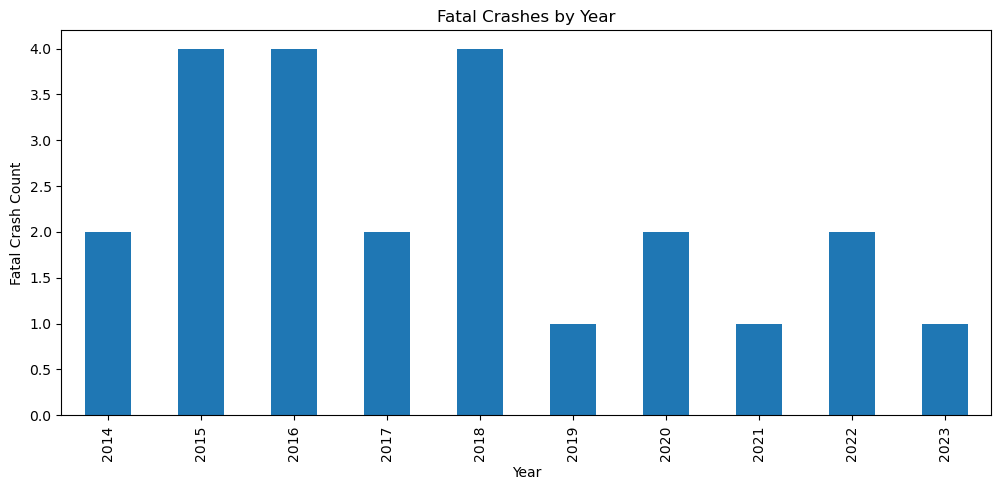

ACCIDENT_YEAR
2014    2
2015    4
2016    4
2017    2
2018    4
2019    1
2020    2
2021    1
2022    2
2023    1
dtype: int64


In [15]:
fatal_by_year = fatal_crashes.groupby('ACCIDENT_YEAR').size()

plt.figure(figsize=(12, 5))
fatal_by_year.plot(kind='bar')
plt.title("Fatal Crashes by Year")
plt.xlabel("Year")
plt.ylabel("Fatal Crash Count")
plt.show()

print(fatal_by_year)

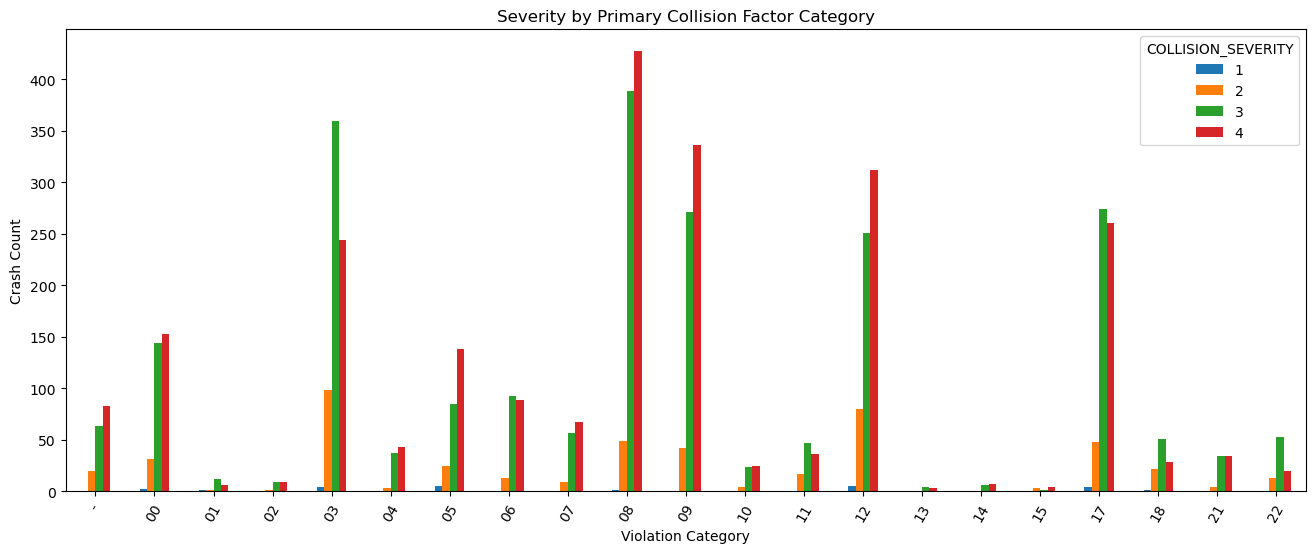

In [16]:
pcf_sev = crashes.groupby(['PCF_VIOL_CATEGORY', 'COLLISION_SEVERITY']).size().unstack(fill_value=0)

pcf_sev.plot(kind='bar', figsize=(16,6))
plt.title("Severity by Primary Collision Factor Category")
plt.xlabel("Violation Category")
plt.ylabel("Crash Count")
plt.xticks(rotation=60)
plt.show()


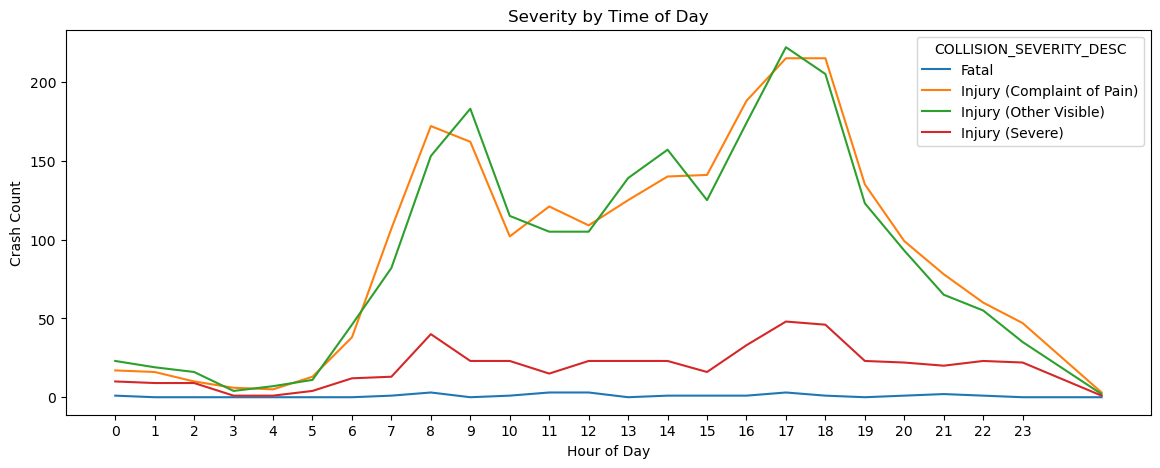

In [17]:
# Extract hour from COLLISION_TIME (HHMM format)
crashes['HOUR'] = crashes['COLLISION_TIME'].astype(str).str.zfill(4).str[:2].astype(int)

hour_sev = crashes.groupby(['HOUR', 'COLLISION_SEVERITY_DESC']).size().unstack(fill_value=0)

hour_sev.plot(kind='line', figsize=(14,5))
plt.title("Severity by Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Crash Count")
plt.xticks(range(0,24))
plt.show()


Collisions appear more likely during the working week and peaks at commute times (early mornings and evenings). 

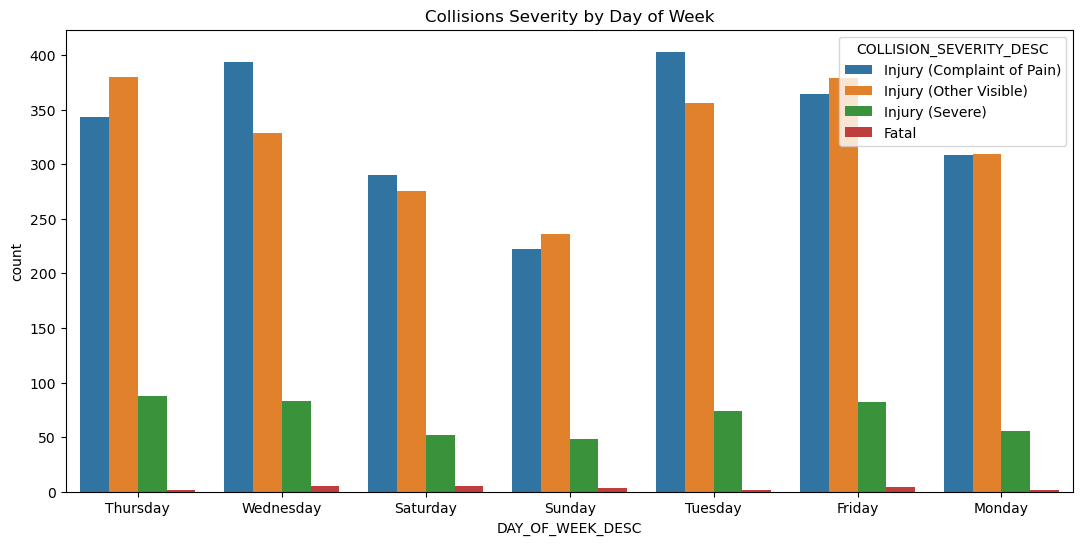

In [18]:
plt.figure(figsize=(13, 6))

sns.countplot(data=crashes, x='DAY_OF_WEEK_DESC', hue='COLLISION_SEVERITY_DESC')

plt.title('Collisions Severity by Day of Week')
plt.show()

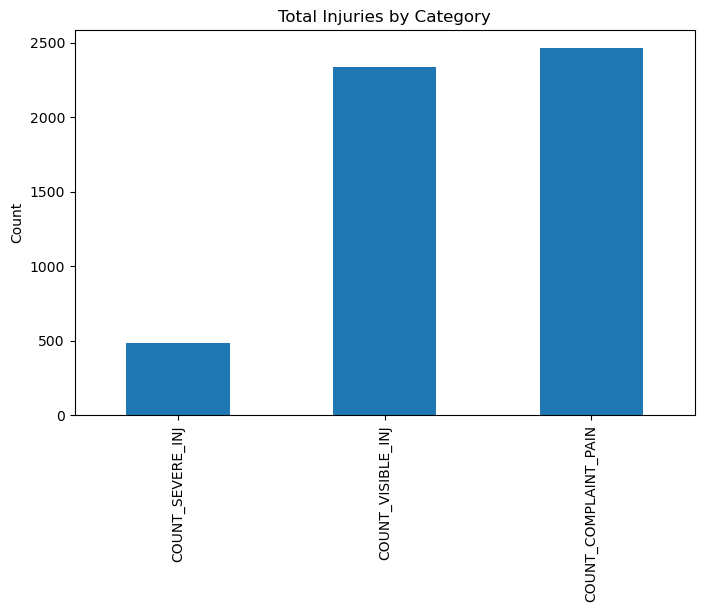

COUNT_SEVERE_INJ         487
COUNT_VISIBLE_INJ       2334
COUNT_COMPLAINT_PAIN    2461
dtype: int64

In [19]:
injury_cols = [
    'COUNT_SEVERE_INJ', 
    'COUNT_VISIBLE_INJ', 
    'COUNT_COMPLAINT_PAIN'
]

injury_totals = crashes[injury_cols].sum()

plt.figure(figsize=(8,5))
injury_totals.plot(kind='bar')
plt.title("Total Injuries by Category")
plt.ylabel("Count")
plt.show()

injury_totals


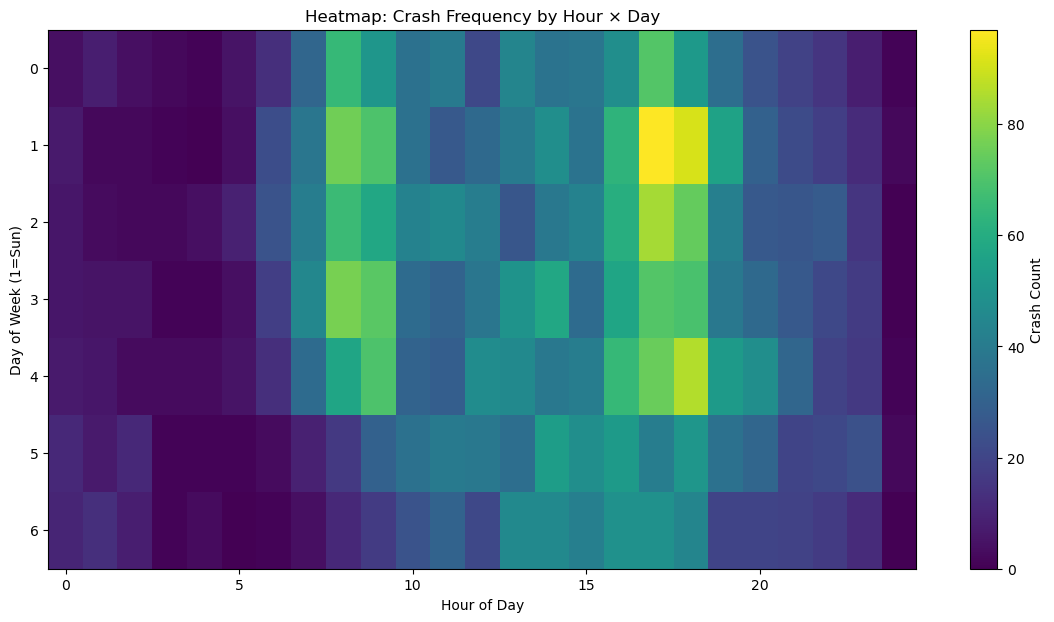

In [20]:
crashes['HOUR'] = crashes['COLLISION_TIME'].astype(str).str.zfill(4).str[:2].astype(int)

pivot = crashes.pivot_table(
    values='CASE_ID',
    index='DAY_OF_WEEK',
    columns='HOUR',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(14,7))
plt.imshow(pivot, aspect='auto')
plt.colorbar(label="Crash Count")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (1=Sun)")
plt.title("Heatmap: Crash Frequency by Hour × Day")
plt.show()


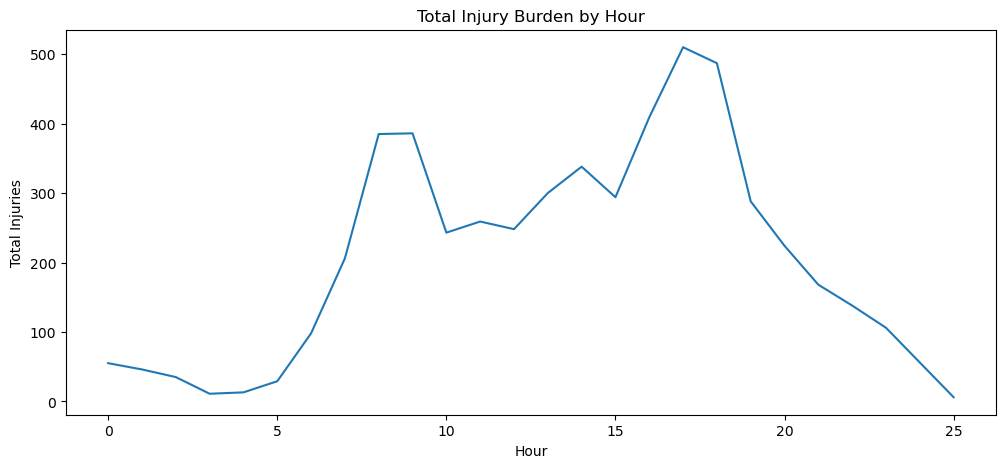

In [21]:
crashes['INJURY_BURDEN'] = (
    crashes['COUNT_SEVERE_INJ'] +
    crashes['COUNT_VISIBLE_INJ'] +
    crashes['COUNT_COMPLAINT_PAIN']
)

inj_by_hour = crashes.groupby('HOUR')['INJURY_BURDEN'].sum()

plt.figure(figsize=(12,5))
inj_by_hour.plot(kind='line')
plt.title("Total Injury Burden by Hour")
plt.xlabel("Hour")
plt.ylabel("Total Injuries")
plt.show()


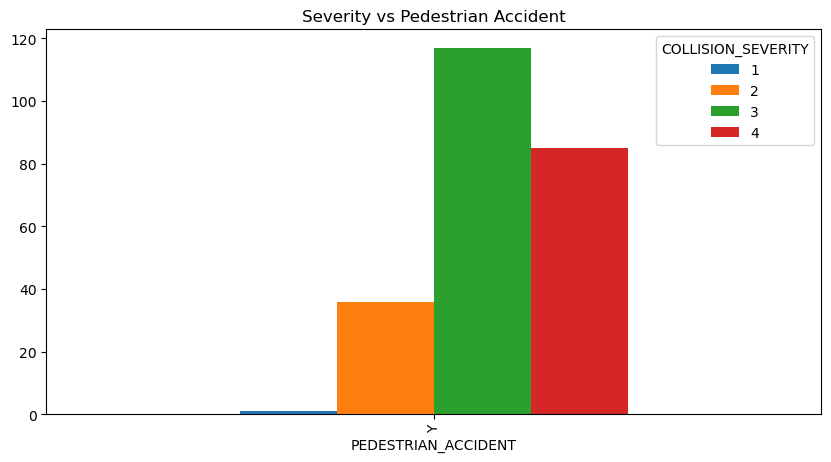

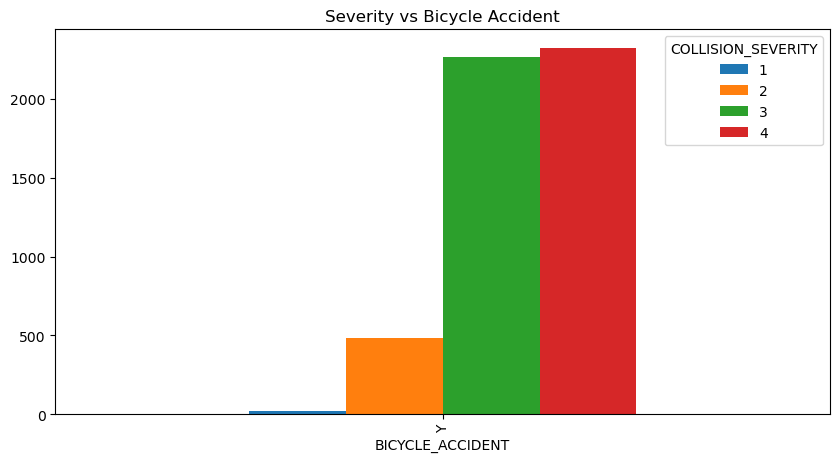

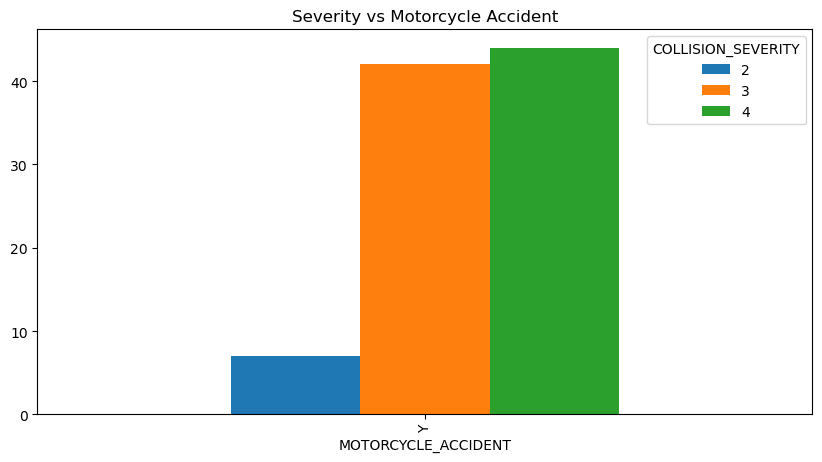

In [22]:
for col in ['PEDESTRIAN_ACCIDENT','BICYCLE_ACCIDENT','MOTORCYCLE_ACCIDENT']:
    temp = crashes.groupby([col,'COLLISION_SEVERITY']).size().unstack(fill_value=0)
    temp.plot(kind='bar', figsize=(10,5))
    plt.title(f"Severity vs {col.replace('_',' ').title()}")
    plt.show()


In [23]:
crashes['PCF_VIOL_CATEGORY_DESC']

0                Improper Turning
1              Unsafe Lane Change
2              Unsafe Lane Change
3                Improper Passing
4       Other Hazardous Violation
                  ...            
5089    Traffic Signals and Signs
5090                      Unknown
5091           Wrong Side of Road
5092                      Unknown
5093      Automobile Right of Way
Name: PCF_VIOL_CATEGORY_DESC, Length: 5094, dtype: object

In [24]:
crashes['PCF_VIOL_CATEGORY'].astype(str).str.strip()

0       08
1       07
2       07
3       06
4       17
        ..
5089    12
5090    00
5091    05
5092    00
5093    09
Name: PCF_VIOL_CATEGORY, Length: 5094, dtype: object

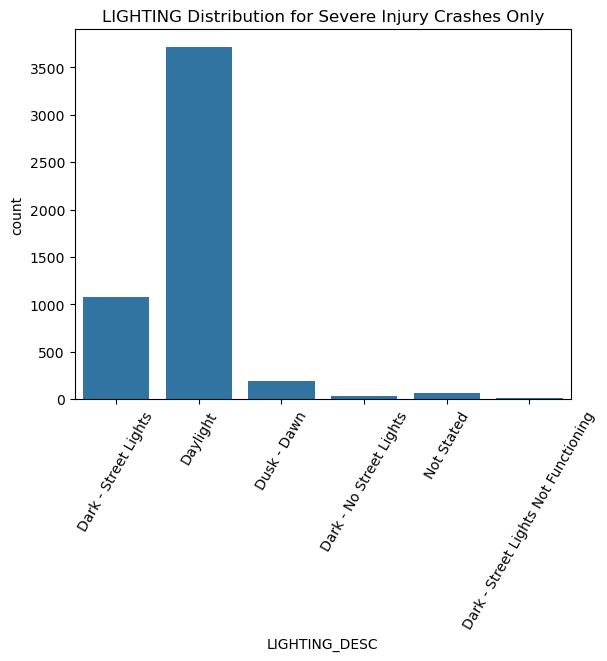

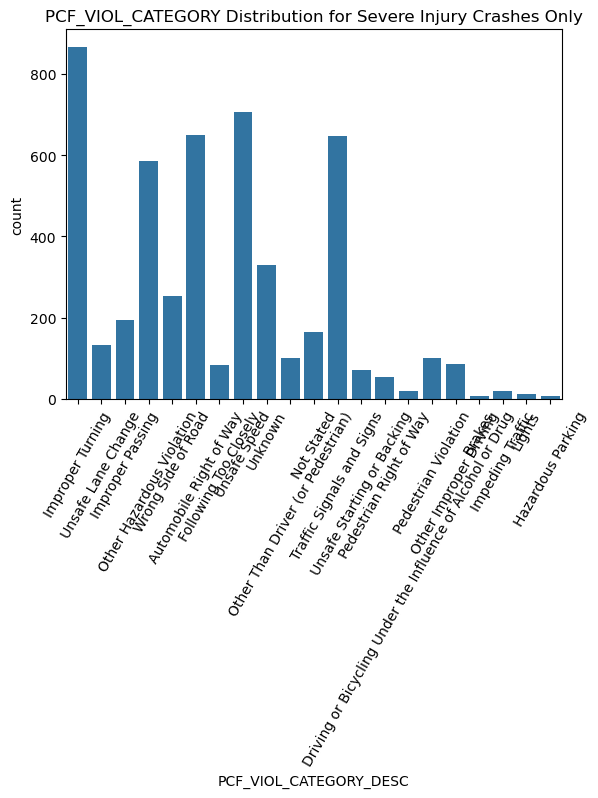

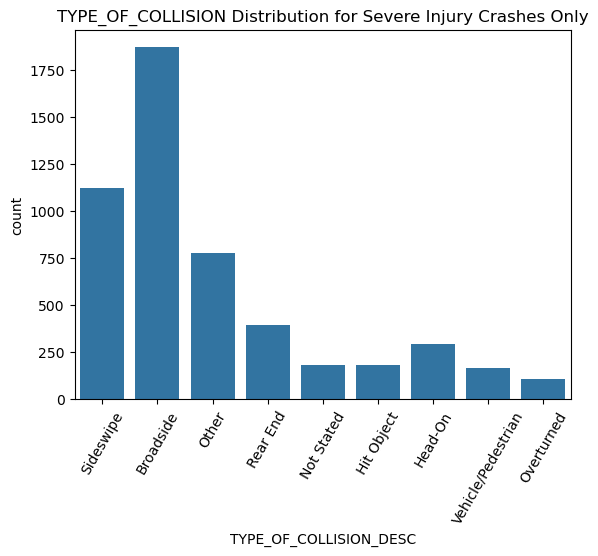

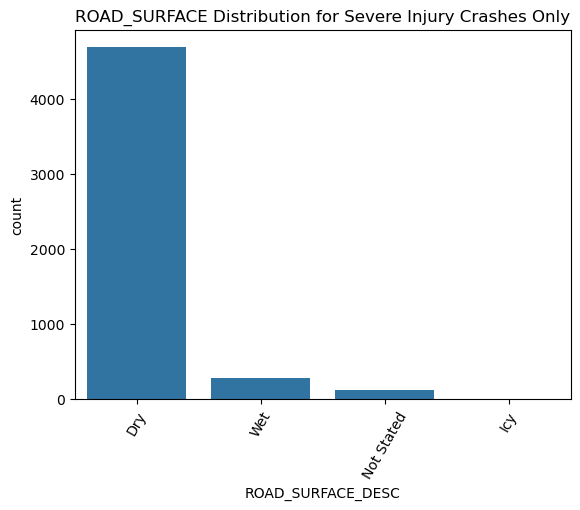

In [25]:
severe = crashes[crashes['COUNT_SEVERE_INJ'] > 0]

for feat in ['LIGHTING', 'PCF_VIOL_CATEGORY', 'TYPE_OF_COLLISION', 'ROAD_SURFACE']:
    featdesc = feat + '_DESC'
    sns.countplot(data=crashes, x=featdesc)
    #severe[feat].value_counts().head(10).plot(kind='bar', figsize=(12,4))
    plt.title(f"{feat} Distribution for Severe Injury Crashes Only")
    plt.xticks(rotation=60)
    plt.show()
